In [1]:
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import numpy as np
import pandas as pd

import json
from glob import glob
import os

from importlib import reload

import utils

import tifffile as tf
from KDEpy import FFTKDE
from scipy import ndimage,stats
from sklearn import preprocessing, tree, metrics, linear_model

In [2]:
level = 'sub'
normtype = 'both'
stepsize = 3
pxs = 75
nuclei_mask_cutoff = 1
ndims = 3
fs = 15
PP = 6
dpi = 96

sigma = 1
pers_w = 1
pixel_size = 1

Cmap='plasma'
s = 50

wong = ['#d81b60', '#b5b5b5', '#6b6b6b', '#000000']
sbkw = dict(label='', size=pxs, loc='upper left', pad=0.5, color='k', frameon=False, size_vertical=7.5)
sbkw1 = dict(label='', size=pxs/stepsize, loc='upper left', pad=0.5, color='lime', frameon=False, size_vertical=7.5/stepsize)
rtkw = dict(ha='right', va='bottom', c='navy', bbox=dict(facecolor='cornsilk', alpha=0.75, boxstyle=mpl.patches.BoxStyle("Square", pad=0.05)))
sample = 'D2'

wsrc = '..' + os.sep + 'cell_dams' + os.sep
nsrc = '..' + os.sep + 'nuclear_mask' + os.sep
ksrc = '..' + os.sep + 'kde' + os.sep + sample + os.sep
isrc = '..' + os.sep + 'infected_focus_summer24' + os.sep + sample + os.sep
gsrc = '..' + os.sep + level + 'level' + os.sep + sample + os.sep
geosrc =  '..' + os.sep + 'geometry' + os.sep + sample + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col='ndimage_cellID')
metaecc = pd.read_csv(ksrc + sample + '_nodule_root_eccentricity.csv', index_col='ndimage_cellID')
cell_nuc = pd.read_csv(ksrc + sample + '_nuclei_limits.csv')

Cells = utils.get_range_cell_values(isrc + 'infected_cells_ids.csv', metacell, startval=1)
Cells = np.setdiff1d( Cells, metacell[metacell['number_nuclei'] > 1].index)

label, cellnum = ndimage.label(tf.imread(wsrc + sample + '_dams.tif').astype(bool), ndimage.generate_binary_structure(2,1))
print('Detected',cellnum,'cells')
#wcoords = np.asarray(np.nonzero(label == 0))
wcoords = np.loadtxt(ksrc + sample + '_icoords.csv', delimiter=',', dtype=int)
wc = wcoords[:, ~np.all(wcoords%100, axis=0)]

lnuc, nnuc = ndimage.label(tf.imread(nsrc + sample + '_EDT.tif') < nuclei_mask_cutoff, ndimage.generate_binary_structure(2,1))
print('Detected',nnuc,'nuclei')

foo = [ wong[-1], wong[-2] ] + np.repeat(wong[1], nnuc).tolist() + ['#f0f0f0']
cellular_cmap = mpl.colors.ListedColormap(foo)

Detected 2937 cells
Detected 1365 nuclei


# Bring in persistence images to the party

In [440]:
exclude_nuclei = True

if exclude_nuclei:
    filenameb = '..' + os.sep + 'translocs' + os.sep + sample + os.sep + 'location_corrected_D2_-_{}.csv'
    ex_nuclei = ''
    pdkw = {'header':None, 'names':['X', 'Y', 'Z']}
else:
    filenameb = '..' + os.sep + 'Bacteria Info for Erik' + os.sep + '{}_v2.txt'
    ex_nuclei = '_w_nucleus'
    pdkw = {'sep':'\t'}

transcell = pd.read_csv(ksrc + sample + '_transcells_metadata' + ex_nuclei + '.csv', index_col='gene').rename(columns=int)
transcriptomes = np.asarray(transcell.index, dtype=str)
Genes = utils.get_range_gene_values(isrc + 'genes_to_focus_infection' + ex_nuclei + '.csv', transcriptomes, startval=0)

translocs = dict()
for key in transcriptomes:
    filename = filenameb.format(key)
    translocs[key] = pd.read_csv(filename, **pdkw)
    translocs[key]['cidx'] = label[ translocs[key]['Y'], translocs[key]['X'] ]
    translocs[key]['nidx'] =  lnuc[ translocs[key]['Y'], translocs[key]['X'] ]
tlocs = pd.concat(translocs)
zmax = np.max(tlocs['Z']+stepsize)
zbins = np.arange(0, zmax+stepsize, stepsize)

transfocus = transcell.loc[ np.atleast_1d( transcriptomes[Genes[ 1 ]]), Cells]
ratios = utils.normalize_counts(transfocus, normtype)
if ratios is None:
    print('ERROR')
genes = '_-_'.join(sorted([ g.replace('GLYMA_', 'Glyma.') for g in ratios.index ]))
print('Max ratio by {}:\t{:.2f}%'.format(normtype, 100*np.max(ratios) ) )
transfocus

Max ratio by both:	0.38%


,169,188,199,209,224,227,233,235,236,243,...,2511,2514,2515,2523,2529,2536,2548,2552,2573,2576
gene,,,,,,,,,,,,,,,,,,,,,
GLYMA_05G092200,456,1687,637,503,465,481,627,971,684,324,...,654,818,199,407,1065,417,428,711,345,477


In [441]:
SCALE = 24
bw = 15

foo = '{}{}/{}_-_{}_p{}_s{}_bw{}_c{:06d}.json'
jsonfiles = dict()
for t in transfocus.index:
    jsonfiles[t] = [ foo.format(gsrc, t, t, level, PP, stepsize, bw, Cells[i]) for i in range(ratios.shape[1]) ]

orig_diags = utils.get_diagrams(jsonfiles, ndims, remove_inf=True)
diags, rescale, maxlife, focus_dim = utils.normalize_persistence_diagrams(orig_diags, ratios, normtype, SCALE)
maxxlife = max( list(map(np.max, iter(maxlife.values()))) )

kde_max = np.zeros(ratios.size); i = 0
for gene in diags:
    for cidx in diags[gene]:
        if len(diags[gene][cidx][2]) > 0:
            kde_max[i] = np.max(diags[gene][cidx][2])
            i += 1

q1,q3 = np.quantile(kde_max, [0.25,0.75])
kmax = min([kde_max.max(), q3 + 1.5*(q3-q1)])

Initial number of life-birth pairs	: 58278

No. of diagrams s.t. H_k had the most persistent component
H_0:	0 [ 0.0% ]
H_1:	0 [ 0.0% ]
H_2:	918 [ 100.0% ]

Will focus just on dimension k = 2



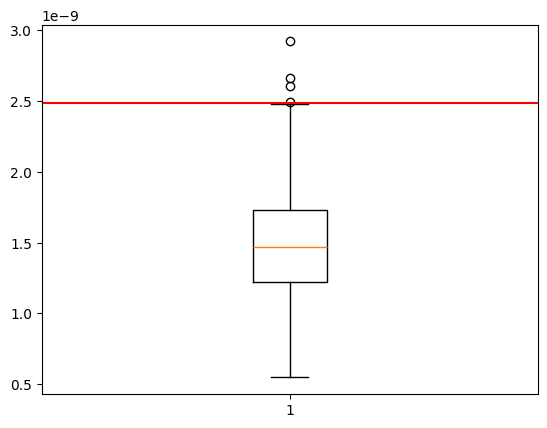

In [442]:
plt.boxplot(kde_max)
plt.axhline(kmax, c='r')

In [443]:
KBINS_NO = 27
foo = [pd.DataFrame(np.zeros((transfocus.shape[0], KBINS_NO-1)), index=transfocus.index, columns=range(1,KBINS_NO)) for _ in range(len(Cells))]
peripherality = dict(zip( Cells, foo ))
for cidx in Cells:
    for gidx in transfocus.index:
        filename = geosrc + '{}/{}_bins_peripherality_c{:06d}.csv'.format(gidx, KBINS_NO-1, cidx)
        foo = pd.read_csv(filename)
        ys = ratios.loc[gidx , cidx] * foo['mean_{}'.format(bw)].values / kmax
        peripherality[cidx].loc[gidx, :] = ys

peri = np.zeros(len(peripherality)*(KBINS_NO-1))
for i,cidx in enumerate(peripherality):
    peri[i*(KBINS_NO-1):(i+1)*(KBINS_NO-1)] = peripherality[cidx].values.squeeze()
periq = np.quantile(peri, .5)

peripherality[778]

,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,24,25,26
gene,,,,,,,,,,,,,,,,,,,,,
GLYMA_05G092200,0.080763,0.09353,0.098371,0.092198,0.079396,0.062751,0.046586,0.033095,0.022559,0.014183,...,3.785329e-07,5.115165e-09,9.428802e-11,9.428801e-11,9.428801e-11,9.428802e-11,9.428802e-11,9.428802e-11,9.428802e-11,9.428802e-11


# Loadings

In [445]:
reload(utils)
pss=np.s_[4:-4]

cc = ['m', 'b', 'r', 'mae', 'start', 'stop']
colnames = []
for gidx in transfocus.index:
    colnames += [ '{}_-_{}'.format(gidx, c) for c in cc ]
colnames = np.asarray(colnames)

df = pd.DataFrame(np.zeros( (len(Cells), len(colnames)) ) , index=Cells, columns=colnames)
for cidx in Cells:
    for gidx in transfocus.index:
        t = gidx + '_-_'
        Ys = peripherality[cidx].loc[gidx].values
        if np.sum(Ys[pss] > periq) > 1:
            tol_msk, labels, where = utils.get_largest_element(Ys[pss] > periq, outlabels=True)
            tplus = np.nonzero(labels)[0][-1]
            tp = 0
            while (tplus < len(tol_msk)-1) & (tp <= -1):
                tplus += 1
                tp += 1
                tol_msk[tplus] = True
            slopes = np.ediff1d(np.hstack([Ys[pss],[Ys[pss][-1]]]))/(Xs[1] - Xs[0])
            mq = np.quantile(np.abs(slopes), .75)
            if np.sum(slopes[tol_msk] > -mq) > np.sum(slopes[tol_msk] < mq):
                tol_msk[tol_msk] = slopes[tol_msk] > -mq
            else:
                tol_msk[tol_msk] = slopes[tol_msk] < mq

            gle_thr = 0.3
            tol_msk, _, where = utils.get_largest_element(tol_msk, thr=gle_thr, outlabels=True)
            while (len(where) > 1) & (gle_thr < 0.33):
                gle_thr += 0.01
                tol_msk, _, where = utils.get_largest_element(tol_msk, thr=gle_thr, outlabels=True)
        else:
            tol_msk = np.ones(len(Ys[pss]), dtype=bool)
            
        ys = Ys[pss][tol_msk]
        xs = Xs[pss][tol_msk]
    
        linregress = stats.linregress(xs, ys)
        m,b,r = linregress.slope, linregress.intercept, np.abs(linregress.rvalue)
        mae = metrics.mean_absolute_error(ys, m*xs + b)
        
        df.loc[cidx, t + 'm'] = m
        df.loc[cidx, t + 'b'] = b
        df.loc[cidx, t + 'r'] = r
        df.loc[cidx, t + 'mae'] = mae
        df.loc[cidx, t + 'start'] = xs[0]
        df.loc[cidx, t + 'stop'] = xs[-1]
print(df.shape)

(918, 6)


In [383]:
df.sort_values(by=gidx + '_-_mae', ascending=False).head(10)

,GLYMA_17G195900_-_m,GLYMA_17G195900_-_b,GLYMA_17G195900_-_r,GLYMA_17G195900_-_mae,GLYMA_17G195900_-_start,GLYMA_17G195900_-_stop
994,0.325898,0.151914,0.779055,0.046032,0.16,0.84
757,0.244685,0.275172,0.863064,0.026144,0.16,0.84
931,0.277721,0.081451,0.811864,0.024939,0.36,0.84
308,0.164128,0.261963,0.791853,0.022914,0.16,0.84
655,0.077694,0.307599,0.518361,0.022505,0.16,0.84
1278,0.109534,0.188789,0.645083,0.020886,0.16,0.84
693,0.155889,0.348521,0.799207,0.020809,0.16,0.84
721,0.136331,0.200847,0.763840,0.020542,0.16,0.84
560,0.110687,0.203835,0.687409,0.020139,0.16,0.84
2170,0.050921,0.332323,0.421530,0.019781,0.16,0.84


In [317]:
df.describe()

,GLYMA_17G195900_-_m,GLYMA_17G195900_-_b,GLYMA_17G195900_-_r,GLYMA_17G195900_-_mae,GLYMA_17G195900_-_start,GLYMA_17G195900_-_stop
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,0.057936,0.152305,0.707830,0.005669,0.247146,0.808627
std,0.104350,0.081908,0.278228,0.004204,0.156542,0.085923
min,-0.130077,-0.784884,0.001274,0.000000,0.160000,0.240000
25%,0.003709,0.118684,0.529076,0.002843,0.160000,0.840000
50%,0.039540,0.158704,0.811939,0.004745,0.160000,0.840000
75%,0.086965,0.189572,0.940307,0.007349,0.280000,0.840000
max,1.301314,0.401396,1.000000,0.046032,0.800000,0.840000


# Plot results

In [446]:
cellloc = metacell.loc[Cells, ['ndimage_comX','ndimage_comY','orig_cellID']].values
metaecc = pd.read_csv(ksrc + sample + '_nodule_root_eccentricity.csv', index_col='ndimage_cellID')
metaecc['eccentricity'] = metaecc['eccentricity'].max() - metaecc['eccentricity'].values
ecc = metaecc.loc[Cells, 'eccentricity'].values

In [447]:
rtkw = dict(ha='right', va='bottom', c='navy', bbox=dict(facecolor='cornsilk', alpha=0.75, boxstyle=mpl.patches.BoxStyle("Square", pad=0.05)))

-1.0272459134469893	0.09534464321864251


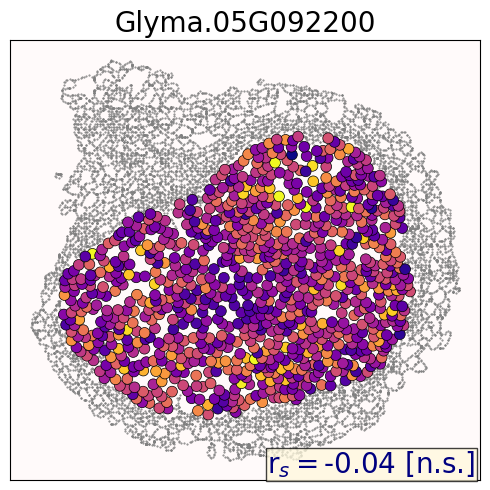

In [448]:
fs = 20
fig, ax = plt.subplots(1, 1, figsize=(5,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

for i in range(len(transfocus)):
    t = transfocus.index[i]
    c = df[t+'_-_m'].values
    corr = stats.spearmanr(c, ecc)
    ll = 'r$_s = ${:.2f} [{}]'.format(corr.statistic, utils.star_signif(corr.pvalue, mx=3))
    ax[i].text(0.99,0, ll, transform=ax[i].transAxes, fontsize=fs, **rtkw)
    
    vmax = utils.maximum_qq_size(c, alpha=0.25, iqr_factor=1.5)
    vmin = utils.minimum_qq_size(c, alpha=0.25, iqr_factor=1.5)

    ax[i].scatter(wc[1], wc[0], c='#808080', marker='.', s=1, zorder=1)
    ax[i].scatter(*cellloc.T[:2], c=c, marker='o', cmap=Cmap+'_r',
                  edgecolor='black', linewidth=0.5, zorder=2, s=3*fs, vmax=vmax, vmin=vmin)
    ax[i].set_title(genes, fontsize=fs)
    ax[i].set_facecolor('snow')
    ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    
    print(vmin, vmax, sep='\t')
fig.tight_layout()
filename = geosrc + t + '_peripherality_nodule_spatial.png'
plt.savefig(filename, dpi=dpi, bbox_inches='tight', pil_kwargs={'optimize':True})

0.31914009803683613


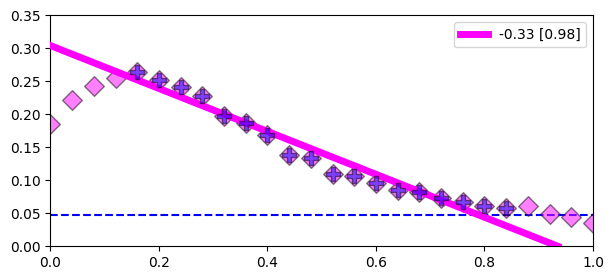

In [449]:
reload(utils)
pss_ = 4
pss= np.s_[pss_ : -pss_]
kbins = np.linspace(0, 1, KBINS_NO)
Xs = np.linspace(0, 1, KBINS_NO-1)

cidx = 2170
fig, ax = plt.subplots(1,1, figsize=(7,3), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j = 0
ax[j].axhline(periq, c='b', ls='--', zorder=1)

for gidx in transfocus.index:
    t = gidx + '_-_'
    Ys = peripherality[cidx].loc[gidx].values
    
    if np.sum(Ys[pss] > periq) > 1:
        tol_msk, labels, where = utils.get_largest_element(Ys[pss] > periq, outlabels=True)
        tplus = np.nonzero(labels)[0][-1]
        tp = 0
        while (tplus < len(tol_msk)-1) & (tp <= -1):
            tplus += 1
            tp += 1
            tol_msk[tplus] = True
        slopes = np.ediff1d(np.hstack([Ys[pss],[Ys[pss][-1]]]))/(Xs[1] - Xs[0])
        mq = np.quantile(np.abs(slopes), .75)
        print(mq)
        if np.sum(slopes[tol_msk] > -mq) > np.sum(slopes[tol_msk] < mq):
            tol_msk[tol_msk] = slopes[tol_msk] > -mq
        else:
            tol_msk[tol_msk] = slopes[tol_msk] < mq
        gle_thr = 0.3
        tol_msk, _, where = utils.get_largest_element(tol_msk, thr=gle_thr, outlabels=True)
        while (len(where) > 1) & (gle_thr < 0.33):
            gle_thr += 0.01
            tol_msk, _, where = utils.get_largest_element(tol_msk, thr=gle_thr, outlabels=True)
            print(gle_thr)
        
    else:
        tol_msk = np.ones(len(Ys[pss]), dtype=bool)
    
    ys = Ys[pss][tol_msk]
    xs = Xs[pss][tol_msk]

    linregress = stats.linregress(xs, ys)
    m,b,r = linregress.slope, linregress.intercept, np.abs(linregress.rvalue)
    mae = metrics.mean_absolute_error(ys, m*xs + b)

    ax[j].scatter(Xs, Ys, color='magenta', marker='D', edgecolor='k', s=100, zorder=2, alpha=0.5)
    ax[j].axline( (xs[0], m*xs[0] + b), slope=m, c='magenta' , zorder=3, lw=5, label='{:.2f} [{:.2f}]'.format(m,r))
    ax[j].scatter(xs, ys, color='b', marker='P', edgecolor='k', s=100, zorder=4, alpha=0.5)

    #print('--\n', np.round(Ys[pss] * np.ediff1d(Ys)[pss.start-1:pss.stop], 5),'\n')
ax[j].legend()
ax[j].set_xlim(0,1)
ax[j].set_ylim(0, max([peripherality[cidx].max(axis=None), 0.3])+0.05);

In [450]:
cidxs = df.sort_values(by=gidx + '_-_m').index[::180]

halpha, hkde, hedt, hcells, hcoords, hextent = [ [None for _ in range(len(cidxs))] for _ in range(6) ]

for i,cidx in enumerate(cidxs):
    cell, cextent = utils.get_cell_img(cidx, metacell, label, lnuc, nnuc, PP=6)
    s_ = (np.s_[cextent[2]:cextent[3]], np.s_[cextent[0]:cextent[1]])
    edt = ndimage.distance_transform_edt(label[s_] == cidx)
    edt = edt/edt.max()
    axes, grid, kdegmask, cgrid, outside_walls = utils.cell_grid_preparation(cidx, cell, label[s_], cextent, zmax, stepsize, cell_nuc)
    
    cellhist = np.digitize(edt, kbins, right=True)
    temp = (1e6*np.hstack(([0], peripherality[cidx].loc[gidx].values))).astype(int)
    with np.nditer(cellhist, flags=['external_loop'], op_flags=['readwrite']) as it:
        for x in it:
            x[...] = temp[x]

    coords = translocs[gidx].loc[ translocs[gidx]['cidx'] == cidx , ['X', 'Y', 'Z'] ].values.T
    
    kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(coords.T).evaluate(grid)
    kde = kde[kdegmask]/(np.sum(kde[kdegmask])*(stepsize**len(coords)))
    kde[outside_walls] = 0
    
    kde = kde/(np.sum(kde)*(stepsize**len(coords)))
    kde = kde.reshape( list(map(len, axes))[::-1], order='F')
    
    hkde[i] = kde * ratios.loc[gidx, cidx]
    hcoords[i] = coords
    hcells[i] = cell
    halpha[i] = min([1.5*int(4e6/cell.size)/100, 0.8])
    hedt[i] = cellhist
    hextent[i] = cextent

loc_kmax = max(map(np.max, hkde))
loc_smax = 1e6*loc_kmax/kmax

In [451]:
color = ['#cc79a7', '#009e73', '#0072b2', '#d55e00', '#e69f00', '#56b4e9']
sbkw = dict(label='', size=pxs, loc='upper left', pad=0.5, color='k', frameon=False, size_vertical=7.5)
sbkw1 = dict(label='', size=pxs/stepsize, loc='upper left', pad=0.5, color='lime', frameon=False, size_vertical=7.5/stepsize)
sbkw2 = dict(label='', size=pxs, loc='upper left', pad=0.5, color='lime', frameon=False, size_vertical=7.5)

../geometry/D2/Glyma.05G092200_peripherality.png


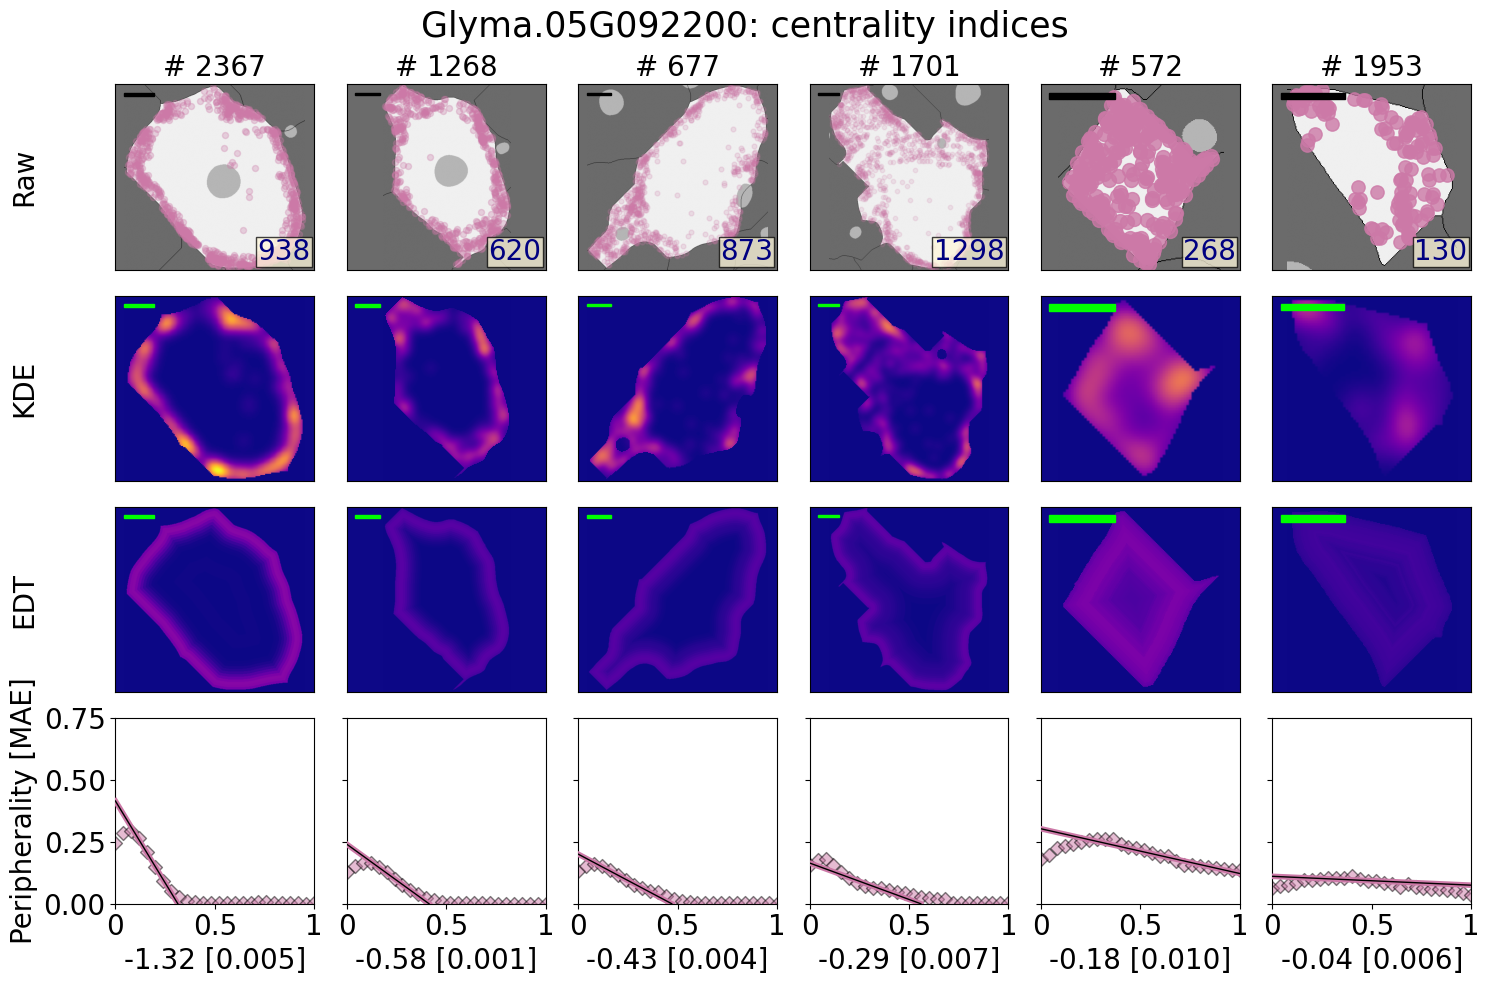

In [456]:
cix = 0
N = len(cidxs)
fs = 20
fig, ax = plt.subplots(4, N, figsize=(2.5*N, 10), sharex=False, sharey=False)
for i in range(N):
    k = i
    cidx = cidxs[k]
    j = 0
    ax[j,i].imshow(hcells[k]+1, cmap=cellular_cmap, origin='lower', extent=hextent[k], vmin=0, vmax=nnuc+2);
    ax[j,i].scatter(*(hcoords[k][:2]), color=color[cix], marker='o', alpha=halpha[k], s=int(4e6/hcells[k].size))
    ax[j,i].set_facecolor(wong[2])
    ax[j,i].set_title('# {}'.format(cidx), fontsize=fs)
    ax[j,i].text(0.98,0.02, hcoords[i].shape[1], transform=ax[j,i].transAxes, fontsize=fs, **rtkw)
    ax[j,i].add_artist(AnchoredSizeBar(ax[j,i].transData, **sbkw))

    j += 1
    ax[j,i].imshow(np.max(hkde[k], axis=0), origin='lower', cmap=Cmap, vmin=0, vmax=loc_kmax, zorder=1)
    ax[j,i].set_facecolor( mpl.colormaps[ Cmap ](0) )
    ax[j,i].add_artist(AnchoredSizeBar(ax[j,i].transData, **sbkw1))

    j += 1
    ax[j,i].imshow(hedt[k], origin='lower', cmap=Cmap, vmin=0, vmax=loc_smax)
    ax[j,i].set_facecolor( mpl.colormaps[ Cmap ](0) )
    ax[j,i].add_artist(AnchoredSizeBar(ax[j,i].transData, **sbkw2))

    j += 1
    Ys = peripherality[cidx].loc[gidx].values
    m,b,mae,start,stop = df.loc[cidx, [gidx + '_-_' + c for c in ['m','b','mae','start','stop']]].values
    
    ax[j,i].scatter(Xs, Ys, color=color[cix], marker='D', edgecolor='k', s=50, zorder=2, alpha=0.5)
    ax[j,i].axline( [ start, m*start + b], slope=m, c=color[cix] , zorder=3, lw=4)
    ax[j,i].axline( [ start, m*start + b], slope=m, c='k' , zorder=4, lw=1)
    ax[j,i].set_xlabel('{:.2f} [{:.3f}]'.format(m,mae), fontsize=fs)
    ax[j,i].set_xlim(0, 1)
    ax[j,i].set_ylim(0, 0.75);
    ax[j,i].tick_params(labelsize=fs)
    ax[j,i].set_xticks([0,0.5,1],[0,0.5,1])

ylabs = ['Raw', 'KDE', 'EDT', 'Peripherality [MAE]']
for i in range(len(ylabs)):
    ax[i,0].set_ylabel(ylabs[i], fontsize=fs)

for a in ax.ravel()[:3*N]:
    a.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    a.set_aspect('equal', 'datalim')

for a in ax.ravel()[-N+1:]:
    a.tick_params(bottom=True, labelbottom=True, left=True, labelleft=False)

fig.suptitle(genes + ': centrality indices', fontsize=1.25*fs)
fig.align_labels()  # same as fig.align_xlabels(); fig.align_ylabels()
fig.tight_layout()
q = 'least'
if k > N:
    q = 'most'
filename = geosrc + genes + '_peripherality.png'
print(filename)
plt.savefig(filename, dpi=dpi, bbox_inches='tight', pil_kwargs={'optimize':True})

In [458]:
filename = geosrc + '{}/{}_bins_bw{}_S{}_peripherality_resumed.csv'.format(gidx, KBINS_NO-1, bw, SCALE)
print(filename)
df.to_csv(filename, index=False)

../geometry/D2/GLYMA_05G092200/26_bins_bw15_S24_peripherality_resumed.csv


In [410]:
df.sort_values(by=gidx + '_-_m').index

Index([1777, 1334, 1434,  759,  303,  882, 1130, 2161, 1546, 1062,
       ...
        938, 2021, 1613, 1812, 2354, 2226, 1349, 1954, 1480,  853],
      dtype='int64', length=918)

# Piecewise linear approximation

In [9]:
cc = ['m', 'b', 'len', 'start', 'stop', 'contig']
ce = ['MAPE', 'MAE', 'MSE']

colnames = []
dtypes = {}

for gidx in Genes:
    for n_seg in [2,3]:
        for j in range(n_seg):
            colnames += [ '{}-L{}{}-{}'.format(transcriptomes[gidx], n_seg, j, c) for c in cc ]
            for c in ['len', 'start', 'stop']:
                dtypes['{}-L{}{}-{}'.format(transcriptomes[gidx], n_seg, j, c)] = int
            dtypes['{}-L{}{}-{}'.format(transcriptomes[gidx], n_seg, j, 'contig')] = bool
        colnames += [ '{}-L{}-{}'.format(transcriptomes[gidx], n_seg, c) for c in ce ]

colnames = np.asarray(colnames)

In [17]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
data = np.zeros( (len(Cells), len(colnames)) )

for i in range(len(Cells)):
    cidx = Cells[i]
    kcol = 0
    for gidx in Genes:
        
        ys = peripherality[cidx].loc[gidx].values[pss]
        
        dys = np.gradient(ys, xs)
        
        for n_seg in [2,3]:
            #print(cidx, gidx, n_seg, sep='\t')
            rgr = tree.DecisionTreeRegressor(max_leaf_nodes=n_seg)
            rgr.fit(xs.reshape(-1, 1), dys.reshape(-1, 1))
            dys_dt = rgr.predict(xs.reshape(-1, 1)).flatten()
            
            uq, idxs, cts = np.unique(dys_dt, return_inverse=True, return_counts=True)
            css = ndimage.find_objects(idxs+1)
            
            contig = [ css[j][0].stop - css[j][0].start  == cts[j] for j in range(len(css)) ]
            
            y_pred = np.copy(ys)
            for j in range(len(css)):
                if cts[j] > 1:
                    linregress = stats.linregress(xs[css[j]], ys[css[j] ])
                    m, b = linregress.slope, linregress.intercept
                    y_pred[ css[j] ] = m*xs[ css[j] ] + b
                    data[i, kcol : kcol+6] = [m, b, cts[j], css[j][0].start, css[j][0].stop, contig[j] ]
                kcol += 6

            data[i, kcol] = metrics.mean_absolute_percentage_error(ys, y_pred); kcol += 1
            data[i, kcol] = metrics.mean_absolute_error(ys, y_pred); kcol += 1
            data[i, kcol] = metrics.mean_squared_error(ys, y_pred); kcol += 1

In [18]:
df = pd.DataFrame(data, index=Cells, columns=colnames).astype(dtypes)
for gidx in Genes:
    t = transcriptomes[gidx]
    df[t+'_L'] = np.where( (df[ t+'-L2-MAE' ] - df[ t+'-L3-MAE' ] < 0.005).values, 2, 3)

c = [t+'_peripherality' for t in transcriptomes[Genes]]
c += [t+'_lenpct' for t in transcriptomes[Genes]]
c += [t+'_MAE' for t in transcriptomes[Genes]]
peri = pd.DataFrame(np.zeros((len(Cells), len(c))), index=Cells, columns=c)

for cidx in Cells:
    for gidx in Genes:
        t = transcriptomes[gidx]
        n_seg = df.loc[cidx, t+'_L']
        
        k = df.loc[cidx, ['{}-L{}{}-len'.format(t, n_seg, k) for k in range(n_seg)] ].argmax()
        peri.loc[cidx, '{}_peripherality'.format(t)] = df.loc[cidx, '{}-L{}{}-m'.format(t, n_seg, k)]
        peri.loc[cidx, '{}_lenpct'.format(t)] = df.loc[cidx, '{}-L{}{}-len'.format(t, n_seg, k)]
        peri.loc[cidx, '{}_MAE'.format(t)] = df.loc[cidx, '{}-L{}-MAE'.format(t, n_seg)]

for gidx in Genes:
    peri[transcriptomes[gidx] + '_lenpct'] = peri[transcriptomes[gidx] + '_lenpct']/len(xs)

In [30]:
idx = df[df['GLYMA_05G092200_L'] == 3].index.values
peri.loc[idx].sort_values(by = 'GLYMA_05G092200_peripherality', ascending=False).head()

,GLYMA_17G195900_peripherality,GLYMA_05G092200_peripherality,GLYMA_17G195900_lenpct,GLYMA_05G092200_lenpct,GLYMA_17G195900_MAE,GLYMA_05G092200_MAE
2219,0.387817,0.020805,0.526316,0.473684,0.004181,0.001866
2226,0.113142,-0.013951,0.631579,0.526316,0.001805,0.002183
883,0.220557,-0.081768,0.526316,0.473684,0.004317,0.002449
1347,0.058888,-0.132565,0.789474,0.473684,0.001274,0.001824
1881,0.081479,-0.165505,0.684211,0.684211,0.004979,0.003443


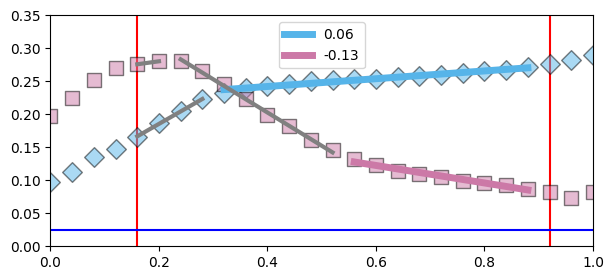

In [215]:
cidx = 1347

fig, ax = plt.subplots(1,1, figsize=(7,3), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j = 0

ax[j].axvline(Xs[pss.start], c='r', zorder=1)
ax[j].axvline(Xs[pss.stop], c='r', zorder=1)
ax[j].axhline(0.025, c='b', zorder=1)
xs = Xs[pss]
for gidx in Genes:
    t = transcriptomes[gidx]
    n_seg = df.loc[cidx, t+'_L']
    Ys = peripherality[cidx].loc[gidx].values

    ax[j].scatter(Xs, Ys, color=Cs[gidx], marker=Ms[gidx], edgecolor='k', s=100, zorder=2, alpha=0.5)

    k = df.loc[cidx, ['{}-L{}{}-len'.format(t, n_seg, k) for k in range(n_seg)] ].argmax()
    m, b = df.loc[cidx, [ '{}-L{}{}-{}'.format(t, n_seg, k, c) for c in ['m','b'] ] ].values.astype(float)
    start, stop = df.loc[cidx, [ '{}-L{}{}-{}'.format(t, n_seg, k, c) for c in ['start','stop'] ] ].values.astype(int)
    stop -= 1
    ax[j].plot( [ xs[start], xs[stop] ], [m*xs[start] + b, m*xs[stop]+b], c=Cs[gidx] , zorder=3, lw=5, label='{:.2f}'.format(m))

    for k in np.setdiff1d(range(n_seg), [k]):
        m, b = df.loc[cidx, [ '{}-L{}{}-{}'.format(t, n_seg, k, c) for c in ['m','b'] ] ].values.astype(float)
        ll, start, stop = df.loc[cidx, [ '{}-L{}{}-{}'.format(t, n_seg, k, c) for c in ['len', 'start','stop'] ] ].values.astype(int)
        stop -= 1
        ax[j].plot( [ xs[start], xs[stop] ], [m*xs[start] + b, m*xs[stop]+b], c='gray' , zorder=4, lw=3)


ax[j].legend()
ax[j].set_xlim(0,1)
ax[j].set_ylim(0, max([peripherality[cidx].max(axis=None), 0.3])+0.05);